# **Amazon Product Rate Predictor**
### JeongYoon Lee, Dovid Scheinberg, Andrew Chu
---
The goal of this project is to predict the number of stars a buyer would rate a product, given their text review of it.

*Code based on Homework 3*

Import the necessary libraries. *(need to remove the ones we don't need)*

In [ ]:
!pip install datasets
!pip install transformers

import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AdamW
import os
# from sklearn.metrics import precision_score, recall_score, f1_score # classification metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # regression metrics
from datasets import load_dataset
import matplotlib.pyplot as plt
torch.manual_seed(42)
np.random.seed(42)

     |████████████████████████████████| 342 kB 7.0 MB/s 
     |████████████████████████████████| 212 kB 61.4 MB/s 
     |████████████████████████████████| 136 kB 64.0 MB/s 
     |████████████████████████████████| 84 kB 4.3 MB/s 
     |████████████████████████████████| 1.1 MB 55.4 MB/s 
     |████████████████████████████████| 127 kB 78.2 MB/s 
     |████████████████████████████████| 271 kB 49.9 MB/s 
     |████████████████████████████████| 144 kB 71.7 MB/s 
     |████████████████████████████████| 94 kB 4.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 4.2 MB 9.6 MB/s 


Load the [amazon_reviews_multi](https://huggingface.co/datasets/amazon_reviews_multi/viewer/en) (English) dataset from [Hugging Face](https://huggingface.co/).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
%cd '/content/gdrive/My Drive/project/submission folder/'

/content/gdrive/.shortcut-targets-by-id/12bQn6IHlaXgvQmuiFGjGLbNC0j_L-m2j/project/submission folder


In [ ]:
train_data = load_dataset("amazon_reviews_multi", "en", split='train')
val_data   = load_dataset("amazon_reviews_multi", "en", split='validation')
test_data  = load_dataset("amazon_reviews_multi", "en", split='test')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/200000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Dataset amazon_reviews_multi downloaded and prepared to /root/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609. Subsequent calls will reuse this data.


Reusing dataset amazon_reviews_multi (/root/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)
Reusing dataset amazon_reviews_multi (/root/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


In [ ]:
print(train_data)
print(val_data)
print(test_data)

Dataset({
    features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
    num_rows: 200000
})
Dataset({
    features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
    num_rows: 5000
})
Dataset({
    features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
    num_rows: 5000
})


# **The Distilbert Model Class**
---
Since we are going to be assigning a text review to a number of stars out of 5 , we will use regression instead of classification.

In [ ]:
class Distilbert():

  def __init__(self, model_name='distilbert-base-uncased', num_labels=1): #I guess our labels are 5 since there are 5 stars  <-  it should be 1 since we're doing regression
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)
    self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels) # num_labels = 1 is for regression

  def get_tokenizer_and_model(self):
    return self.model, self.tokenizer

# **The Dataloader Class**
---
Since we are going to be rating a product out of 5 stars based on a text review, we will use regression.

In [ ]:
import random
class DatasetLoader(Dataset):

  def __init__(self, data, tokenizer):
    self.data = data
    self.tokenizer = tokenizer

  def tokenize_data(self):
    print("Processing data..")
    tokens = []
    labels = []

    review_list = self.data['review_body']
    title_list = self.data['review_title']
    label_list = self.data['stars']
    data = list(zip(review_list, label_list, title_list))
    random.shuffle(data)
    num_training = 20000
    data = data[:num_training]
    for review, label, title in tqdm(data, total=len(data)):
      review_encoding = self.tokenizer.encode_plus(title + review, truncation=True, max_length = 512)
      review_encoding = review_encoding['input_ids']
      review_encoding = torch.tensor(review_encoding).cuda()

      tokens.append(review_encoding)
      labels.append(np.float32(label)/5)
      
    tokens = pad_sequence(tokens, batch_first=True)
    labels = torch.tensor(labels)
    dataset = TensorDataset(tokens, labels)
    return dataset

  def get_data_loaders(self, batch_size=32, shuffle=True):
    processed_dataset = self.tokenize_data()

    data_loader = DataLoader(
        processed_dataset,
        shuffle=shuffle,
        batch_size=batch_size
    )

    return data_loader

# **The Trainer Class**
---

In [ ]:
from sklearn.metrics import accuracy_score
class Trainer():

  def __init__(self, options):
    self.device = options['device']
    self.train_data = options['train_data']
    self.val_data = options['val_data']
    self.batch_size = options['batch_size']
    self.epochs = options['epochs']
    self.save_path = options['save_path']
    transformer = Distilbert()
    self.model, self.tokenizer = transformer.get_tokenizer_and_model()
    self.model.to(self.device)

  def get_performance_metrics(self, preds, labels):
    pred_flat = (preds)
    labels_flat = labels.flatten()
    pred_flat = torch.round(pred_flat*5)
    labels_flat = torch.round(labels_flat*5)

    mse = mean_squared_error(labels_flat, pred_flat)
    mae = mean_absolute_error(labels_flat, pred_flat)
    r2 = r2_score(labels_flat, pred_flat)
    acc = accuracy_score(labels_flat*5, pred_flat*5)
    return mse, mae, r2, acc

  def set_training_parameters(self):
    # layer_nums = ["layer.0", "layer.1", "layer.2", "layer.3", "layer.4", "layer.5"] # Training only the last 2 layers, so freeze the first 4
    layer_nums = ["layer.0", "layer.1", "layer.2", "layer.3"] # Training only the last 2 layers, so freeze the first 4

    for name, layer in self.model.named_parameters():
      if any([x in name for x in layer_nums]) or "embeddings" in name:
        layer.requires_grad = False

  def train(self, data_loader, optimizer):
    self.model.train()
    total_mse = 0
    total_mae = 0
    total_r2 = 0
    total_loss = 0
    total_acc = 0
    
    loader = tqdm(data_loader)
    for batch_idx, (reviews, labels) in enumerate(loader):
      self.model.zero_grad()

      optimizer.zero_grad()
      outputs = self.model(reviews.to(self.device), labels=labels.to(self.device).float())
      cur_loss = outputs.loss.to(self.device).float()
      
      cur_loss.backward()
      optimizer.step()

      total_loss += cur_loss
      result = self.get_performance_metrics(outputs['logits'].cpu().detach(), labels.cpu().detach()) # results are always filled with 0's. Need to fix
      total_mse += result[0]
      total_mae += result[1]
      total_r2 += result[2]
      total_acc += result[3]
      loader.set_description(f'current loss: {cur_loss} pred {outputs["logits"][0]} label {labels[0]} acc: {result[3]}')

    mse = total_mse/len(data_loader)
    mae = total_mae/len(data_loader)
    r2 = total_r2/len(data_loader)
    loss = total_loss/len(data_loader)
    acc = total_acc/len(data_loader)

    return mse, mae, r2, loss, acc

  def eval(self, data_loader):
    self.model.eval()
    total_mse = 0
    total_mae = 0
    total_r2 = 0
    total_loss = 0
    total_acc = 0

    with torch.no_grad():
      for (reviews, labels) in tqdm(data_loader):
        
        labels = labels.to(self.device)
        outputs = self.model(reviews.to(self.device), labels = labels.to(self.device).float())
        cur_loss = outputs.loss
      
        total_loss += cur_loss
        result = self.get_performance_metrics(outputs['logits'].cpu().detach(), labels.cpu().detach())
        total_mse += result[0]
        total_mae += result[1]
        total_r2 += result[2]
        total_acc += result[3]
    
    mse = total_mse/len(data_loader)
    mae = total_mae/len(data_loader)
    r2 = total_r2/len(data_loader)
    loss = total_loss/len(data_loader)
    acc = total_acc/len(data_loader)

    return mse, mae, r2, loss, acc

  def save_transformer(self):
    self.model.save_pretrained(self.save_path)
    self.tokenizer.save_pretrained(self.save_path)

  def execute(self):
    last_best = 0
    train_dataset = DatasetLoader(self.train_data, self.tokenizer)
    train_data_loader = train_dataset.get_data_loaders(self.batch_size)
    val_dataset = DatasetLoader(self.val_data, self.tokenizer)
    val_data_loader = val_dataset.get_data_loaders(self.batch_size)
    optimizer = AdamW(self.model.parameters(), lr = 0.00003, eps = 1e-8)
    self.set_training_parameters()
    plt_epochs = range(1, self.epochs +1)
    plt_train_mse = []
    plt_val_mse = []
    plt_train_mae = []
    plt_val_mae = []
    plt_train_r2 = []
    plt_val_r2 = []
    plt_train_acc = []
    plt_val_acc = []
    plt_train_loss = []
    plt_val_loss = []


    for epoch_i in range(0, self.epochs):
      train_mse, train_mae, train_r2, train_loss, train_acc = self.train(train_data_loader, optimizer)
      plt_train_mse.append(train_mse)
      plt_train_mae.append(train_mae)
      plt_train_r2.append(train_r2)
      plt_train_acc.append(train_acc)
      plt_train_loss.append(train_loss.detach().cpu().numpy())
      print(f'Epoch {epoch_i + 1}: train_loss: {train_loss:.4f} train_mse: {train_mse:.4f} train_mae: {train_mae:.4f} train_r2: {train_r2:.4f} train_acc: {train_acc:.4f}')
      val_mse, val_mae, val_r2, val_loss, val_acc = self.eval(val_data_loader)
      plt_val_mse.append(val_mse)
      plt_val_mae.append(val_mae)
      plt_val_r2.append(val_r2)
      plt_val_acc.append(val_acc)
      plt_val_loss.append(val_loss.detach().cpu().numpy())
      print(f'Epoch {epoch_i + 1}: val_loss: {val_loss:.4f} val_mse: {val_mse:.4f} val_mae: {val_mae:.4f} val_r2: {val_r2:.4f} val_acc: {val_acc:.4f}')

      if val_acc > last_best:
        print("Saving model..")
        self.save_transformer()
        last_best = val_r2
        print("Model saved.")

    plt.plot(plt_epochs, plt_train_mse,'bo-', label = 'Training MSE')
    plt.plot(plt_epochs, plt_val_mse, 'ro-',label = "Validation MSE")
    plt.title('Training and validation MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

    plt.plot(plt_epochs, plt_train_mae,'bo-', label = 'Training MAE')
    plt.plot(plt_epochs, plt_val_mae, 'ro-',label = "Validation MAE")
    plt.title('Training and validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

    plt.plot(plt_epochs, plt_train_r2,'bo-', label = 'Training r2')
    plt.plot(plt_epochs, plt_val_r2, 'ro-',label = "Validation r2")
    plt.title('Training and validation r2')
    plt.xlabel('Epochs')
    plt.ylabel('r2')
    plt.legend()
    plt.show()
    
    plt.plot(plt_epochs, plt_train_acc,'bo-', label = 'Training Accuracy')
    plt.plot(plt_epochs, plt_val_acc, 'ro-',label = "Validation Accuracy")
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(plt_epochs, plt_train_loss, 'bo-', label = 'Training Loss')
    plt.plot(plt_epochs, plt_val_loss, 'ro-',label = "Validation Loss")
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# **Training**
---

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

Processing data..


100%|██████████| 20000/20000 [00:05<00:00, 3817.74it/s]


Processing data..


100%|██████████| 5000/5000 [00:01<00:00, 3688.45it/s]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
current loss: 0.023882882669568062 pred tensor([0.3934], device='cuda:0', grad_fn=<SelectBackward0>) label 0.4 acc: 0.375: 100%|██████████| 1250/1250 [08:48<00:00,  2.37it/s]


Epoch 1: train_loss: 0.0367 train_mse: 0.9982 train_mae: 0.7023 train_r2: 0.4488 train_acc: 0.4310


100%|██████████| 313/313 [01:22<00:00,  3.80it/s]


Epoch 1: val_loss: 0.0276 val_mse: 0.7604 val_mae: 0.5715 val_r2: 0.5724 val_acc: 0.5126
Saving model..
Model saved.


current loss: 0.026770684868097305 pred tensor([0.3380], device='cuda:0', grad_fn=<SelectBackward0>) label 0.4 acc: 0.3125: 100%|██████████| 1250/1250 [08:47<00:00,  2.37it/s]


Epoch 2: train_loss: 0.0231 train_mse: 0.6579 train_mae: 0.5280 train_r2: 0.6297 train_acc: 0.5311


100%|██████████| 313/313 [01:22<00:00,  3.79it/s]


Epoch 2: val_loss: 0.0227 val_mse: 0.6346 val_mae: 0.4916 val_r2: 0.6438 val_acc: 0.5723


current loss: 0.013121763244271278 pred tensor([0.6268], device='cuda:0', grad_fn=<SelectBackward0>) label 0.4 acc: 0.6875: 100%|██████████| 1250/1250 [08:47<00:00,  2.37it/s]


Epoch 3: train_loss: 0.0203 train_mse: 0.5810 train_mae: 0.4834 train_r2: 0.6742 train_acc: 0.5616


100%|██████████| 313/313 [01:22<00:00,  3.80it/s]


Epoch 3: val_loss: 0.0221 val_mse: 0.6230 val_mae: 0.4784 val_r2: 0.6448 val_acc: 0.5849
Saving model..
Model saved.


current loss: 0.04439845308661461 pred tensor([0.9446], device='cuda:0', grad_fn=<SelectBackward0>) label 1.0 acc: 0.5625: 100%|██████████| 1250/1250 [08:47<00:00,  2.37it/s]


Epoch 4: train_loss: 0.0184 train_mse: 0.5347 train_mae: 0.4501 train_r2: 0.6972 train_acc: 0.5894


100%|██████████| 313/313 [01:22<00:00,  3.80it/s]


Epoch 4: val_loss: 0.0222 val_mse: 0.6296 val_mae: 0.4798 val_r2: 0.6360 val_acc: 0.5835


current loss: 0.016228806227445602 pred tensor([0.4851], device='cuda:0', grad_fn=<SelectBackward0>) label 0.6 acc: 0.5: 100%|██████████| 1250/1250 [08:47<00:00,  2.37it/s]


Epoch 5: train_loss: 0.0163 train_mse: 0.4823 train_mae: 0.4182 train_r2: 0.7278 train_acc: 0.6116


100%|██████████| 313/313 [01:22<00:00,  3.80it/s]


Epoch 5: val_loss: 0.0217 val_mse: 0.6144 val_mae: 0.4758 val_r2: 0.6516 val_acc: 0.5851


current loss: 0.02115536481142044 pred tensor([0.3919], device='cuda:0', grad_fn=<SelectBackward0>) label 0.6 acc: 0.375: 100%|██████████| 1250/1250 [08:46<00:00,  2.37it/s]


Epoch 6: train_loss: 0.0144 train_mse: 0.4304 train_mae: 0.3855 train_r2: 0.7569 train_acc: 0.6359


100%|██████████| 313/313 [01:22<00:00,  3.80it/s]


Epoch 6: val_loss: 0.0220 val_mse: 0.6272 val_mae: 0.4738 val_r2: 0.6473 val_acc: 0.5919


current loss: 0.009150252677500248 pred tensor([0.9169], device='cuda:0', grad_fn=<SelectBackward0>) label 1.0 acc: 0.625: 100%|██████████| 1250/1250 [08:47<00:00,  2.37it/s]


Epoch 7: train_loss: 0.0128 train_mse: 0.3901 train_mae: 0.3563 train_r2: 0.7781 train_acc: 0.6602


100%|██████████| 313/313 [01:22<00:00,  3.80it/s]


Epoch 7: val_loss: 0.0261 val_mse: 0.7244 val_mae: 0.5136 val_r2: 0.5877 val_acc: 0.5749


current loss: 0.016031531617045403 pred tensor([0.1812], device='cuda:0', grad_fn=<SelectBackward0>) label 0.2 acc: 0.5625: 100%|██████████| 1250/1250 [08:46<00:00,  2.37it/s]


Epoch 8: train_loss: 0.0116 train_mse: 0.3553 train_mae: 0.3305 train_r2: 0.7985 train_acc: 0.6814


100%|██████████| 313/313 [01:22<00:00,  3.80it/s]


Epoch 8: val_loss: 0.0222 val_mse: 0.6346 val_mae: 0.4828 val_r2: 0.6448 val_acc: 0.5813


current loss: 0.01217858400195837 pred tensor([0.3743], device='cuda:0', grad_fn=<SelectBackward0>) label 0.4 acc: 0.6875: 100%|██████████| 1250/1250 [08:46<00:00,  2.38it/s]


Epoch 9: train_loss: 0.0103 train_mse: 0.3222 train_mae: 0.3039 train_r2: 0.8167 train_acc: 0.7048


100%|██████████| 313/313 [01:22<00:00,  3.80it/s]


Epoch 9: val_loss: 0.0237 val_mse: 0.6492 val_mae: 0.4850 val_r2: 0.6345 val_acc: 0.5869


current loss: 0.008249334990978241 pred tensor([0.4623], device='cuda:0', grad_fn=<SelectBackward0>) label 0.4 acc: 0.75: 100%|██████████| 1250/1250 [08:47<00:00,  2.37it/s]


Epoch 10: train_loss: 0.0093 train_mse: 0.2958 train_mae: 0.2832 train_r2: 0.8312 train_acc: 0.7230


100%|██████████| 313/313 [01:22<00:00,  3.80it/s]


Epoch 10: val_loss: 0.0239 val_mse: 0.6775 val_mae: 0.4842 val_r2: 0.6063 val_acc: 0.5990


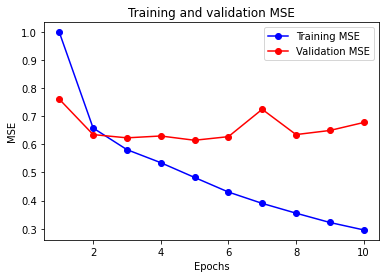

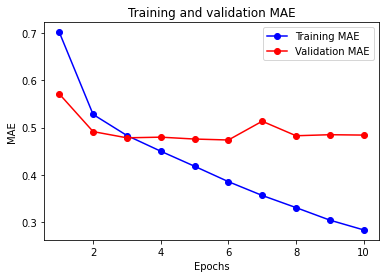

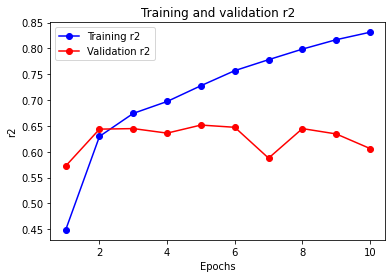

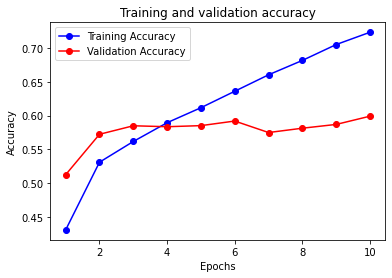

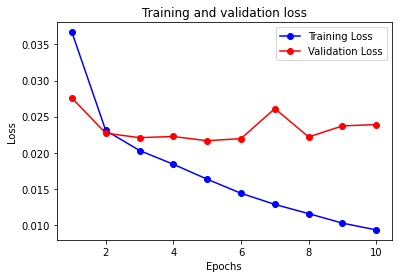

In [ ]:
options = {}
options['batch_size'] = 16
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['train_data'] = train_data
options['val_data'] = val_data
options['save_path'] = "Distilbert_regression"
options['epochs'] = 10
trainer = Trainer(options)
trainer.execute()